In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T

In [20]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self,lr,n_actions,input_dims):
        super(LinearDeepQNetwork,self).__init__()
        
        self.fc1 = nn.Linear(*input_dims,128)
        self.fc2 = nn.Linear(128,n_actions)
        
        self.optimizer = optim.Adam(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')

        self.to(self.device)
        
    def forward(self,state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)
        
        return actions
    

class Agent():
    def __init__(self,lr,input_dims,n_actions,gamma=.99,epsilon=1,eps_min=0.01,eps_dec=1-1e-5):
        
        self.lr = lr
        self.input_dims = input_dims
        self.gamma = gamma
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.action_space = [i for i in range(self.n_actions)]
        
        self.Q = LinearDeepQNetwork(self.lr,self.n_actions,self.input_dims)
        
        
    def choose_action(self,observation):
        if np.random.random() < self.epsilon:
            action = np.random.choice([i for i in range(self.n_actions)])
        else:
            state = T.tensor(observation,dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        return action
    
    def decrement_epsilon(self):
        if self.epsilon > self.eps_min:
            self.epsilon = self.epsilon *self.eps_dec
        else:
            self.epsilon = self.eps_min
    
    def learn(self,state,action,reward,state_):
        self.Q.optimizer.zero_grad()
        
        states = T.tensor(state,dtype=T.float).to(self.Q.device)
        actions = T.tensor(action, dtype=T.long).to(self.Q.device)
        rewards = T.tensor(reward, dtype=T.float).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)
        
        q_pred = self.Q.forward(states)[actions]
        
        q_next = self.Q.forward(states_).max()
        
        q_target = reward + self.gamma*q_next
        
        loss = self.Q.loss(q_target,q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()
        

In [21]:
def plot_learning_curve(x, scores, epsilons, filename):
    fig = plt.figure()
    ax = fig.add_subplot(111, label="1")
    ax2 = fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(scores[max(0, t-100):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    plt.savefig(filename)


episode  0 win per 23.00 epsilon 1.00
episode  100 win per 21.93 epsilon 0.98
episode  200 win per 22.56 epsilon 0.96
episode  300 win per 24.41 epsilon 0.93
episode  400 win per 21.50 epsilon 0.91
episode  500 win per 22.89 epsilon 0.89
episode  600 win per 21.26 epsilon 0.87
episode  700 win per 22.34 epsilon 0.85
episode  800 win per 22.60 epsilon 0.84
episode  900 win per 22.75 epsilon 0.82


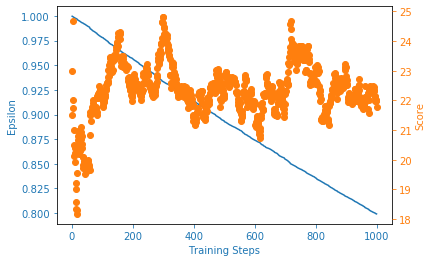

In [22]:
env = gym.make('CartPole-v1')

n_games = 1000
win_pct = []
scores = []
eps_history = []

agent = Agent(lr=0.0001,input_dims=env.observation_space.shape,n_actions=env.action_space.n)


for i in range(n_games):
    done = False
    obs = env.reset()
    score = 0
    while not done:
        
        action = agent.choose_action(obs)
        obs_,reward,done,info = env.step(action)
        agent.learn(obs,action,reward,obs_)
        
        score += reward
        obs = obs_
        
    scores.append(score)
    eps_history.append(agent.epsilon)
    
    if i%100 == 0:
        average = np.mean(scores[-100:])
        win_pct.append(average)
        if i%100 == 0:
            print('episode ',i, 'win per %.2f' % average, 'epsilon %.2f' % agent.epsilon)

filename = 'cartpole_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)



In [23]:
env.observation_space.shape

(4,)